In [1]:
from Utils.Functions import split_data, data_cleaning
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import transformers
from sklearn.metrics import hamming_loss, jaccard_score, label_ranking_average_precision_score, f1_score
from matplotlib import pyplot as plt

In [2]:
random_seed = 0
training_set_size = 0.8
GLOVE_TXT_PATH = '../../GloVe Embeddings/glove.840B.300d.txt'

MAX_LEN = 200 #based on length of tweets
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 1e-05
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
twitter_data = pd.read_csv('Data/labeledEn.csv')
twitter_data = data_cleaning(twitter_data)
twitter_data = twitter_data.drop(['ID'], axis = 1)
train_dataset , test_dataset  = split_data(twitter_data, training_set_size, random_seed)
train_dataset['list'] = train_dataset[train_dataset.columns[1:12]].values.tolist()
train_df = train_dataset[['Tweet', 'list']].copy()
train_df = train_df.reset_index(drop = True)
test_dataset['list'] = test_dataset[test_dataset.columns[1:12]].values.tolist()
test_df = test_dataset[['Tweet', 'list']].copy()
test_df = test_df.reset_index(drop = True)

/mnt/i/Projects/evaluation-deeplearning-NLP/Utils/Functions.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['Tweet'] = dataset['Tweet'].str.replace('<.*?>', '')


In [4]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        self.tweet = dataframe['Tweet']
        self.targets = self.dataframe.list
        self.max_len = max_len

    def __len__(self):
        return len(self.tweet)

    def __getitem__(self, index):
        tweet = str(self.tweet[index])
        tweet = " ".join(tweet.split())

        inputs = self.tokenizer.encode_plus(
            tweet,
            None,
            add_special_tokens = True,
            max_length = self.max_len,
            padding='max_length',
            return_token_type_ids = True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        return {
            'ids' : torch.tensor(ids, dtype = torch.long),
            'mask' : torch.tensor(mask, dtype = torch.long),
            'token_type_ids' : torch.tensor(token_type_ids, dtype = torch.long),
            'targets' : torch.tensor(self.targets[index], dtype = torch.float)
        }

In [5]:
training_set = CustomDataset(train_df, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_df, tokenizer, MAX_LEN)

In [6]:
training_loader = DataLoader(training_set, shuffle = True, batch_size = TRAIN_BATCH_SIZE)
testing_loader = DataLoader(testing_set, shuffle = True, batch_size = VALID_BATCH_SIZE)

In [7]:
class BERT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.layer2 = torch.nn.Dropout(0.2)
        self.layer3 = torch.nn.Linear(768, 11)

    def forward(self, ids, mask, token_type_ids, return_dict = False):
        unw, out_1 = self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[0], self.layer1(ids, attention_mask = mask, token_type_ids = token_type_ids)[1]
        out_2 = self.layer2(out_1)
        out_final = self.layer3(out_2)
        return out_final

model = BERT()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

In [8]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params = model.parameters(), lr = LEARNING_RATE)

In [9]:
def train(epoch):
    model.train()
    total_loss = 0

    for unw, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids, return_dict = False)
        loss = loss_fn(outputs, targets)
        total_loss += loss.item()

        if unw % 2000 == 0:
            print(f'Training Iter : {unw+1}, Epoch: {epoch+1}, Loss: {total_loss/(unw+1)}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # save model
    torch.save(model.state_dict(), f'./Model/bert_model_{epoch}.bin')

def valid():
    model.eval()
    req_targets = []
    req_outputs = []
    valid_loss = 0

    with torch.no_grad():
        for unw, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            valid_loss += loss.item()

            req_targets.extend(targets.cpu().detach().numpy().tolist())
            req_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    valid_loss /= len(testing_loader)
    return req_outputs, req_targets, valid_loss

In [10]:
EPOCHS = 35

micro_f1s = []
macro_f1s = []
test_losses = []

for epoch in range(EPOCHS):
    print('---------------------------------')
    print(f'Epoch {epoch+1}/{EPOCHS}')
    train(epoch)

    print('---------------------------------')
    print('Test Results')
    outputs, targets, valid_loss = valid()
    outputs = np.array(outputs)
    targets = np.array(targets)

    int_outputs = np.zeros((outputs.shape[0], outputs.shape[1]))

    for row in range(outputs.shape[0]):
        for col in range(outputs.shape[1]):
            if outputs[row][col] >= 0.5: int_outputs[row][col] = 1

    bert_ham_loss = hamming_loss(targets, int_outputs)
    bert_jacc_score = jaccard_score(targets, int_outputs, average = 'samples')
    bert_lrap = label_ranking_average_precision_score(targets, outputs)
    bert_f1_macro = f1_score(targets, int_outputs, average = 'macro')
    bert_f1_micro = f1_score(targets, int_outputs, average = 'micro')

    micro_f1s.append(bert_f1_micro)
    macro_f1s.append(bert_f1_macro)
    test_losses.append(valid_loss)

    print("Test Loss:", valid_loss)
    print("Hamming Loss:", bert_ham_loss)
    print("Jaccard Score:", bert_jacc_score)
    print("Label Ranking Average Precision Score:", bert_lrap)
    print("F1 Macro Score:", bert_f1_macro)
    print("F1 Micro Score:", bert_f1_micro)

    print('---------------------------------')

---------------------------------
Epoch 1/35
Training Iter : 1, Epoch: 1, Loss: 0.6810121536254883
---------------------------------
Test Results
Test Loss: 0.36725121378898623
Hamming Loss: 0.15036363636363637
Jaccard Score: 0.32409999999999994
Label Ranking Average Precision Score: 0.7033370713083213
F1 Macro Score: 0.20793548373985377
F1 Micro Score: 0.3941391941391941
---------------------------------
---------------------------------
Epoch 2/35
Training Iter : 1, Epoch: 2, Loss: 0.3668662905693054
---------------------------------
Test Results
Test Loss: 0.3344657062292099
Hamming Loss: 0.13822727272727273
Jaccard Score: 0.42395
Label Ranking Average Precision Score: 0.7476587073112075
F1 Macro Score: 0.2779175527076436
F1 Micro Score: 0.4945986371946152
---------------------------------
---------------------------------
Epoch 3/35
Training Iter : 1, Epoch: 3, Loss: 0.3328512907028198
---------------------------------
Test Results
Test Loss: 0.32869647669792174
Hamming Loss: 0.138

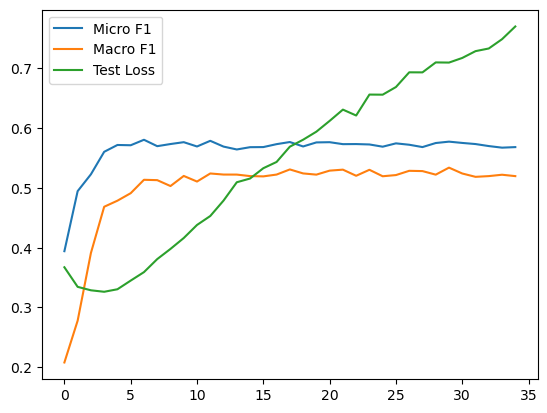

In [11]:
# Plotting the results
plt.plot(micro_f1s, label = 'Micro F1')
plt.plot(macro_f1s, label = 'Macro F1')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()
plt.show()